# Master MVA- Generative Modeling
### Assignment 25th Feb
### Benjamin Deporte

### Import librairies

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Set Up

In [4]:
torch.set_default_dtype(torch.float64)

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(f"Using {device}")

!nvidia-smi

# set seeds for reproductibility
random_seed = 42
rng = np.random.default_rng(seed=random_seed)
torch.manual_seed(random_seed)

Using cpu
/bin/bash: line 1: nvidia-smi: command not found


# 2D-Data

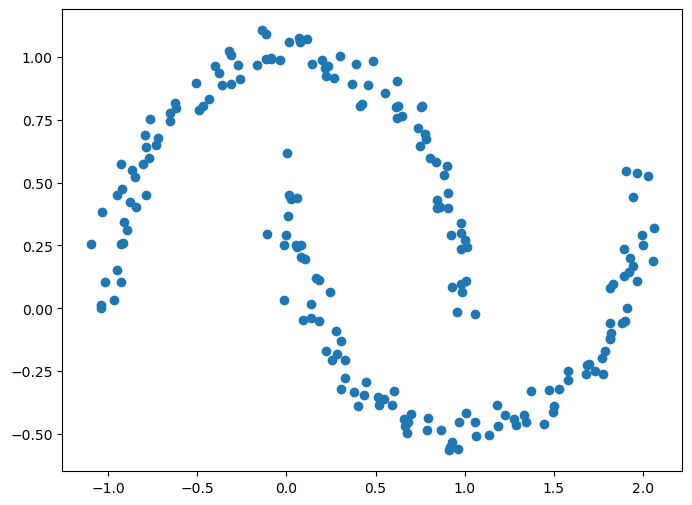

In [3]:
# Soyons fous... nous utiliserons 2-moons ici

from sklearn.datasets import make_moons

# paramètres
N_SAMPLES = 200
NOISE = 0.05

# génération données
X, _ = make_moons(n_samples=N_SAMPLES, noise=NOISE, random_state=random_seed)

# force dans [0,1]^2
# X[:,0] = (X[:,0] - np.min(X[:,0])) / (np.max(X[:,0]) - np.min(X[:,0]))
# X[:,1] = (X[:,1] - np.min(X[:,1])) / (np.max(X[:,1]) - np.min(X[:,1]))

# formate en tensor
X_data = torch.tensor(X)

# plot dataset
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_data.detach().cpu().numpy()[:,0], X_data.detach().cpu().numpy()[:,1])

plt.show()

# GAN Training

In [4]:
# Generator - on ré-utilise le code du TP

class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=device):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        # create nlayers of nn.Linear of size
        # - n_in for the first one
        # - n_hid for the others
        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        # otuput layer, n_out neurons then Sigmoid
        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            # nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()

In [5]:
n_in = 10    # input dimension, dimension de la Gaussienne dont est tiré z
d = 2        # dimension des data points

b = 100      # batch size

# Initialise générateur
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)
z = torch.randn(b, n_in, device=device)
X_gen = G(z).detach().cpu().numpy()

In [6]:
def display(x_data=X_data, x_gen=None):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
    ax.scatter(x_data[:,0], x_data[:,1], c='navy')
    plt.show()

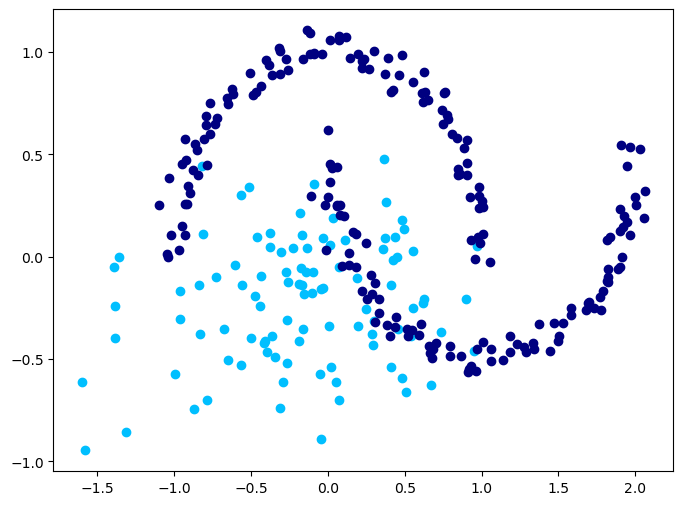

In [7]:
# Teste le sampling

display(X_data, X_gen)

In [8]:
# Discriminator - code TP

class DiscriminatorGAN(nn.Module):
  def __init__(self, n_in=2, n_hid=10, device=device):
    super(DiscriminatorGAN, self).__init__()

    # n_in is the input dimension, 2 here as data points are 2D
    self.n_hid = n_hid
    self.n_in = n_in    

    self.fc1 = nn.Linear(n_in, n_hid).to(device)
    self.fc2 = nn.Linear(n_hid, n_hid).to(device)
    self.fc3 = nn.Linear(n_hid, 1).to(device)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    # proba que x soit issu de p_data et non pas p_gen = G(p_z)
    y = nn.Sigmoid()(self.fc3(y))
    return y

### GAN Training Loop

TP code Evolution :
- commented code regarding gradient clipping
- added kwarg "GenFreeze" to allow training of Discriminator only
- a couple of prints

In [9]:
def train_GAN(
  GenFreeze=False,
  niterD=100,
  niterG=1,
  n_epochs=50,
  lrdisc=1e-2,
  lrgen=1e-3,
  iter_display=10
  ):
  
  # Report out
  print(f"Training GAN - GenFreeze={GenFreeze}")
  # Training loop

  # parameters
  lrgen = lrgen   # learning rate for generator
  lrdisc = lrdisc  # learning rate for discriminator
  n_epochs = n_epochs
  niterD=niterD
  niterG=niterG

  # Initialize generator and discriminator
  G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)
  D = DiscriminatorGAN(n_in=d, n_hid=100, device=device)

  # get ready
  optimG = optim.Adam(G.parameters(), lr=lrgen)
  optimD = optim.Adam(D.parameters(), lr=lrdisc) #, betas=(beta_1, beta_2))

  # logs
  Glosses = []
  Dlosses = []

  # reporting 
  iter_display = iter_display

  # Main loop
  for epoch in range(1,n_epochs):

      ###########################################
      ### Train discriminator (niterD iterations)
      ###########################################
      
      #### ie max sur D de la loss
      for iter in range(0,niterD):
        optimD.zero_grad()
        X_gen = G(torch.randn(b, n_in, device=device))
        Dx = D(X_gen)
        # we want to maximize D(X_data) and minimize D(X_gen)
        # Dloss should be as small as possible
        Dloss = - (torch.mean(D(X_data)) - torch.mean(Dx))
        optimD.zero_grad()
        Dloss.backward()
        optimD.step()
        # GAN : no gradient cliping !
        # for p in D.parameters():
        #     p.data.clamp_(-clip_value, clip_value)

      #######################################
      ### Train generator (niterG iterations)
      #######################################
      ### ie min sur G de la loss
      for iter in range(0,niterG):
        # we want to maximize D(G(z))
        # Gloss should be as small as possible
        Gloss = - torch.mean(D(G(torch.randn(b, n_in, device=device))))
        if GenFreeze is not True:
          optimG.zero_grad()
          Gloss.backward()
          optimG.step()

      # Output training stats
      print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
        % (epoch, n_epochs, Dloss.item(), Gloss.item()))
      Glosses.append(Gloss.item())
      Dlosses.append(Dloss.item())

      # draw pictures from time to time
      if(epoch % iter_display == 0):
          fig, ax = plt.subplots(figsize=(4, 4))
          # plot data
          ax.scatter(X_data[:,0], X_data[:,1], c='navy')
          # plot generated points
          z = torch.randn(b, n_in, device=device)
          x_gen = G(z).detach().cpu().numpy()
          ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
          plt.show()

  ### Plot the evolution of the discriminator and generator losses ###
  plt.figure(dpi=100)
  plt.plot(Dlosses,label='D')
  plt.plot(Glosses,label='G')
  plt.title(f'Loss evolution - GenFreeze={GenFreeze}')
  plt.legend()
  plt.show()

### Training D, fixed G

Ok, we succeed in training D (sort of : -.80 loss vs -1.00 optimal) when G is frozen.

Training GAN - GenFreeze=True
[1/200] 	Loss_D: -0.5629	Loss_G: -0.1807
[2/200] 	Loss_D: -0.6898	Loss_G: -0.0641
[3/200] 	Loss_D: -0.7329	Loss_G: -0.0900
[4/200] 	Loss_D: -0.7240	Loss_G: -0.0442
[5/200] 	Loss_D: -0.7354	Loss_G: -0.0932
[6/200] 	Loss_D: -0.7506	Loss_G: -0.1209
[7/200] 	Loss_D: -0.7731	Loss_G: -0.0807
[8/200] 	Loss_D: -0.7496	Loss_G: -0.1087
[9/200] 	Loss_D: -0.7368	Loss_G: -0.0799
[10/200] 	Loss_D: -0.7614	Loss_G: -0.0502
[11/200] 	Loss_D: -0.7703	Loss_G: -0.0917
[12/200] 	Loss_D: -0.7368	Loss_G: -0.0936
[13/200] 	Loss_D: -0.7600	Loss_G: -0.0710
[14/200] 	Loss_D: -0.7778	Loss_G: -0.0730
[15/200] 	Loss_D: -0.8094	Loss_G: -0.0825
[16/200] 	Loss_D: -0.7564	Loss_G: -0.0440
[17/200] 	Loss_D: -0.7910	Loss_G: -0.0189
[18/200] 	Loss_D: -0.7565	Loss_G: -0.0297
[19/200] 	Loss_D: -0.7458	Loss_G: -0.0832
[20/200] 	Loss_D: -0.7709	Loss_G: -0.0625
[21/200] 	Loss_D: -0.8061	Loss_G: -0.0200
[22/200] 	Loss_D: -0.7719	Loss_G: -0.0598
[23/200] 	Loss_D: -0.7689	Loss_G: -0.0608
[24/200] 	Los

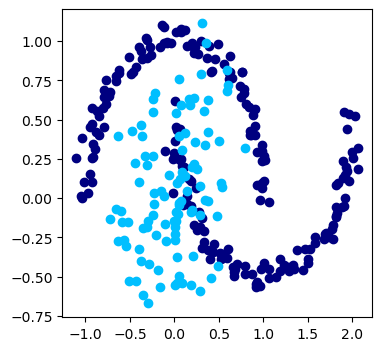

[51/200] 	Loss_D: -0.8029	Loss_G: -0.0946
[52/200] 	Loss_D: -0.8281	Loss_G: -0.0282
[53/200] 	Loss_D: -0.8072	Loss_G: -0.0508
[54/200] 	Loss_D: -0.8206	Loss_G: -0.1089
[55/200] 	Loss_D: -0.8022	Loss_G: -0.0401
[56/200] 	Loss_D: -0.8180	Loss_G: -0.0516
[57/200] 	Loss_D: -0.8393	Loss_G: -0.1092
[58/200] 	Loss_D: -0.7866	Loss_G: -0.0419
[59/200] 	Loss_D: -0.7920	Loss_G: -0.0800
[60/200] 	Loss_D: -0.7810	Loss_G: -0.0210
[61/200] 	Loss_D: -0.8334	Loss_G: -0.0313
[62/200] 	Loss_D: -0.8143	Loss_G: -0.0496
[63/200] 	Loss_D: -0.8430	Loss_G: -0.0591
[64/200] 	Loss_D: -0.8250	Loss_G: -0.0538
[65/200] 	Loss_D: -0.7865	Loss_G: -0.0861
[66/200] 	Loss_D: -0.7987	Loss_G: -0.0514
[67/200] 	Loss_D: -0.8007	Loss_G: -0.0259
[68/200] 	Loss_D: -0.8177	Loss_G: -0.0405
[69/200] 	Loss_D: -0.8031	Loss_G: -0.0601
[70/200] 	Loss_D: -0.8399	Loss_G: -0.0438
[71/200] 	Loss_D: -0.7774	Loss_G: -0.0776
[72/200] 	Loss_D: -0.8316	Loss_G: -0.0435
[73/200] 	Loss_D: -0.8210	Loss_G: -0.0300
[74/200] 	Loss_D: -0.8137	Loss_G: 

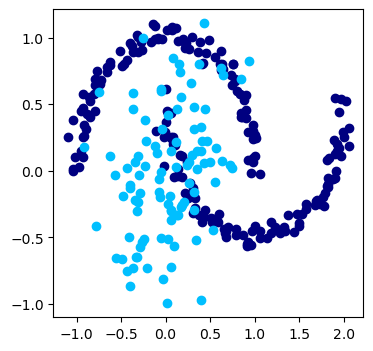

[101/200] 	Loss_D: -0.7897	Loss_G: -0.0516
[102/200] 	Loss_D: -0.8035	Loss_G: -0.0273
[103/200] 	Loss_D: -0.8096	Loss_G: -0.0415
[104/200] 	Loss_D: -0.7905	Loss_G: -0.0781
[105/200] 	Loss_D: -0.7970	Loss_G: -0.0484
[106/200] 	Loss_D: -0.8130	Loss_G: -0.0808
[107/200] 	Loss_D: -0.8326	Loss_G: -0.0704
[108/200] 	Loss_D: -0.8207	Loss_G: -0.0564
[109/200] 	Loss_D: -0.8053	Loss_G: -0.0343
[110/200] 	Loss_D: -0.8047	Loss_G: -0.0399
[111/200] 	Loss_D: -0.8122	Loss_G: -0.0991
[112/200] 	Loss_D: -0.7779	Loss_G: -0.0496
[113/200] 	Loss_D: -0.8055	Loss_G: -0.0291
[114/200] 	Loss_D: -0.7971	Loss_G: -0.0481
[115/200] 	Loss_D: -0.7735	Loss_G: -0.0764
[116/200] 	Loss_D: -0.8036	Loss_G: -0.0307
[117/200] 	Loss_D: -0.8229	Loss_G: -0.0401
[118/200] 	Loss_D: -0.8015	Loss_G: -0.0591
[119/200] 	Loss_D: -0.8450	Loss_G: -0.0479
[120/200] 	Loss_D: -0.7618	Loss_G: -0.0701
[121/200] 	Loss_D: -0.7987	Loss_G: -0.0567
[122/200] 	Loss_D: -0.8210	Loss_G: -0.0566
[123/200] 	Loss_D: -0.8014	Loss_G: -0.0864
[124/200] 	

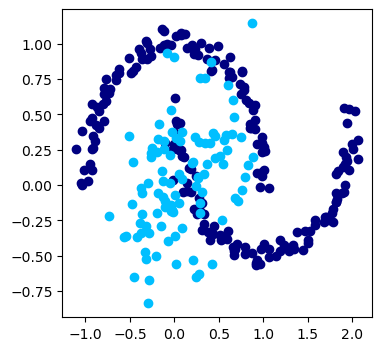

[151/200] 	Loss_D: -0.8146	Loss_G: -0.0938
[152/200] 	Loss_D: -0.8204	Loss_G: -0.0411
[153/200] 	Loss_D: -0.8408	Loss_G: -0.0499
[154/200] 	Loss_D: -0.7794	Loss_G: -0.0583
[155/200] 	Loss_D: -0.8016	Loss_G: -0.0491
[156/200] 	Loss_D: -0.8249	Loss_G: -0.0378
[157/200] 	Loss_D: -0.8056	Loss_G: -0.0632
[158/200] 	Loss_D: -0.8217	Loss_G: -0.0307
[159/200] 	Loss_D: -0.8047	Loss_G: -0.0749
[160/200] 	Loss_D: -0.7913	Loss_G: -0.0502
[161/200] 	Loss_D: -0.7764	Loss_G: -0.0623
[162/200] 	Loss_D: -0.8148	Loss_G: -0.0686
[163/200] 	Loss_D: -0.8295	Loss_G: -0.0497
[164/200] 	Loss_D: -0.7683	Loss_G: -0.0296
[165/200] 	Loss_D: -0.8119	Loss_G: -0.0707
[166/200] 	Loss_D: -0.8036	Loss_G: -0.0500
[167/200] 	Loss_D: -0.8036	Loss_G: -0.0117
[168/200] 	Loss_D: -0.8245	Loss_G: -0.0698
[169/200] 	Loss_D: -0.8285	Loss_G: -0.0800
[170/200] 	Loss_D: -0.8049	Loss_G: -0.0209
[171/200] 	Loss_D: -0.8458	Loss_G: -0.0300
[172/200] 	Loss_D: -0.8345	Loss_G: -0.0657
[173/200] 	Loss_D: -0.8102	Loss_G: -0.0540
[174/200] 	

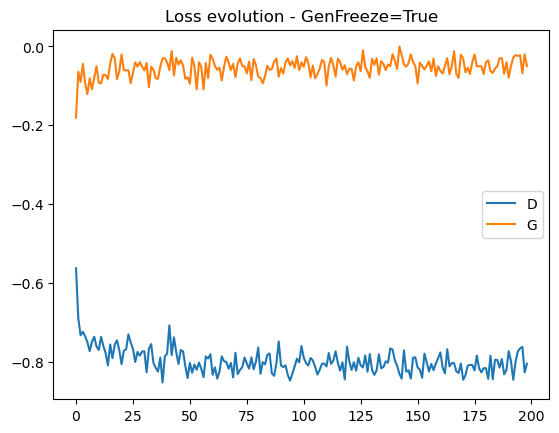

In [10]:
train_GAN(GenFreeze=True, lrdisc=1e-3, n_epochs=200, iter_display=50)

### Full training of D and G

We put 500 training iterations on D for 1 (one !) on G.
Still, training fails.

Training GAN - GenFreeze=False
[1/100] 	Loss_D: -0.4253	Loss_G: -0.1280
[2/100] 	Loss_D: -0.3296	Loss_G: -0.3005
[3/100] 	Loss_D: -0.3153	Loss_G: -0.4771
[4/100] 	Loss_D: -0.1630	Loss_G: -0.4764
[5/100] 	Loss_D: -0.1444	Loss_G: -0.6075
[6/100] 	Loss_D: -0.0958	Loss_G: -0.7021
[7/100] 	Loss_D: -0.1038	Loss_G: -0.7093
[8/100] 	Loss_D: -0.1110	Loss_G: -0.7651
[9/100] 	Loss_D: -0.2243	Loss_G: -0.6660
[10/100] 	Loss_D: -0.4669	Loss_G: -0.5102
[11/100] 	Loss_D: -0.6881	Loss_G: -0.3257
[12/100] 	Loss_D: -0.8009	Loss_G: -0.2115
[13/100] 	Loss_D: -0.7053	Loss_G: -0.2192
[14/100] 	Loss_D: -0.7061	Loss_G: -0.2547
[15/100] 	Loss_D: -0.6696	Loss_G: -0.2727
[16/100] 	Loss_D: -0.6834	Loss_G: -0.3177
[17/100] 	Loss_D: -0.7125	Loss_G: -0.2549
[18/100] 	Loss_D: -0.6031	Loss_G: -0.2758
[19/100] 	Loss_D: -0.7013	Loss_G: -0.3313
[20/100] 	Loss_D: -0.6631	Loss_G: -0.2905
[21/100] 	Loss_D: -0.6527	Loss_G: -0.4094
[22/100] 	Loss_D: -0.6223	Loss_G: -0.4166
[23/100] 	Loss_D: -0.5012	Loss_G: -0.5198
[24/100] 	Lo

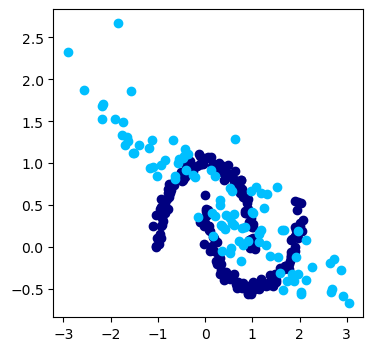

[26/100] 	Loss_D: -0.3899	Loss_G: -0.5404
[27/100] 	Loss_D: -0.3746	Loss_G: -0.6022
[28/100] 	Loss_D: -0.4053	Loss_G: -0.6845
[29/100] 	Loss_D: -0.3946	Loss_G: -0.6544
[30/100] 	Loss_D: -0.2505	Loss_G: -0.7126
[31/100] 	Loss_D: -0.3125	Loss_G: -0.7779
[32/100] 	Loss_D: -0.2524	Loss_G: -0.7146
[33/100] 	Loss_D: -0.1520	Loss_G: -0.8029
[34/100] 	Loss_D: -0.1983	Loss_G: -0.9040
[35/100] 	Loss_D: -0.1049	Loss_G: -0.8153
[36/100] 	Loss_D: -0.0954	Loss_G: -0.8341
[37/100] 	Loss_D: -0.0426	Loss_G: -0.9097
[38/100] 	Loss_D: -0.0435	Loss_G: -0.9498
[39/100] 	Loss_D: -0.0146	Loss_G: -0.9692
[40/100] 	Loss_D: -0.0187	Loss_G: -0.9983
[41/100] 	Loss_D: -0.0001	Loss_G: -0.9997
[42/100] 	Loss_D: 0.0001	Loss_G: -1.0000
[43/100] 	Loss_D: -0.0097	Loss_G: -1.0000
[44/100] 	Loss_D: 0.0007	Loss_G: -1.0000
[45/100] 	Loss_D: -0.0000	Loss_G: -1.0000
[46/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[47/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[48/100] 	Loss_D: 0.0000	Loss_G: -1.0000
[49/100] 	Loss_D: 0.0000	Loss_G: -0.999

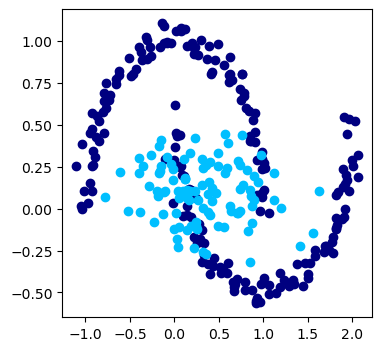

[51/100] 	Loss_D: 0.0001	Loss_G: -1.0000
[52/100] 	Loss_D: 0.0005	Loss_G: -0.9919
[53/100] 	Loss_D: -0.0094	Loss_G: -1.0000
[54/100] 	Loss_D: -0.0411	Loss_G: -0.9344
[55/100] 	Loss_D: -0.4135	Loss_G: -0.2913
[56/100] 	Loss_D: -0.6402	Loss_G: -0.1707
[57/100] 	Loss_D: -0.6927	Loss_G: -0.0482
[58/100] 	Loss_D: -0.6896	Loss_G: -0.0596
[59/100] 	Loss_D: -0.6893	Loss_G: -0.0996
[60/100] 	Loss_D: -0.6657	Loss_G: -0.0828
[61/100] 	Loss_D: -0.6194	Loss_G: -0.1494
[62/100] 	Loss_D: -0.6073	Loss_G: -0.1364
[63/100] 	Loss_D: -0.5943	Loss_G: -0.1911
[64/100] 	Loss_D: -0.5592	Loss_G: -0.1963
[65/100] 	Loss_D: -0.5713	Loss_G: -0.1427
[66/100] 	Loss_D: -0.5545	Loss_G: -0.2776
[67/100] 	Loss_D: -0.4657	Loss_G: -0.2492
[68/100] 	Loss_D: -0.4938	Loss_G: -0.2822
[69/100] 	Loss_D: -0.6106	Loss_G: -0.2394
[70/100] 	Loss_D: -0.5312	Loss_G: -0.2138
[71/100] 	Loss_D: -0.5944	Loss_G: -0.2024
[72/100] 	Loss_D: -0.6506	Loss_G: -0.2234
[73/100] 	Loss_D: -0.6566	Loss_G: -0.1228
[74/100] 	Loss_D: -0.6228	Loss_G: -0

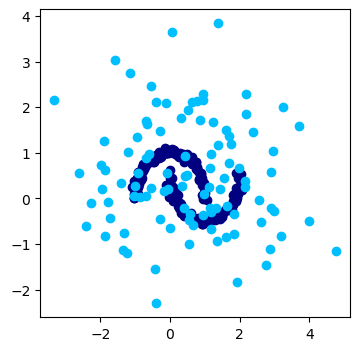

[76/100] 	Loss_D: -0.6498	Loss_G: -0.1850
[77/100] 	Loss_D: -0.6830	Loss_G: -0.1289
[78/100] 	Loss_D: -0.6538	Loss_G: -0.1125
[79/100] 	Loss_D: -0.6100	Loss_G: -0.1222
[80/100] 	Loss_D: -0.6872	Loss_G: -0.1216
[81/100] 	Loss_D: -0.6603	Loss_G: -0.1845
[82/100] 	Loss_D: -0.6721	Loss_G: -0.0931
[83/100] 	Loss_D: -0.6132	Loss_G: -0.1460
[84/100] 	Loss_D: -0.6372	Loss_G: -0.1915
[85/100] 	Loss_D: -0.7246	Loss_G: -0.1045
[86/100] 	Loss_D: -0.6443	Loss_G: -0.1713
[87/100] 	Loss_D: -0.6838	Loss_G: -0.1772
[88/100] 	Loss_D: -0.7064	Loss_G: -0.1652
[89/100] 	Loss_D: -0.6486	Loss_G: -0.1359
[90/100] 	Loss_D: -0.6948	Loss_G: -0.1397
[91/100] 	Loss_D: -0.6082	Loss_G: -0.1858
[92/100] 	Loss_D: -0.6910	Loss_G: -0.1267
[93/100] 	Loss_D: -0.6608	Loss_G: -0.1864
[94/100] 	Loss_D: -0.6832	Loss_G: -0.1854
[95/100] 	Loss_D: -0.5993	Loss_G: -0.1277
[96/100] 	Loss_D: -0.5781	Loss_G: -0.1914
[97/100] 	Loss_D: -0.6526	Loss_G: -0.2087
[98/100] 	Loss_D: -0.6630	Loss_G: -0.2037
[99/100] 	Loss_D: -0.5568	Loss_G: 

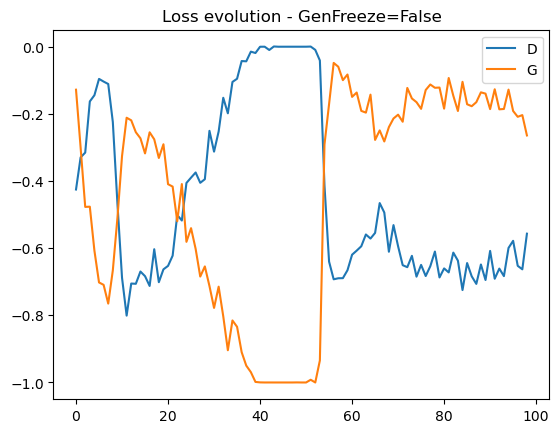

In [11]:
train_GAN(GenFreeze=False, niterD=100, lrdisc=1e-3, n_epochs=100, iter_display=25)

### Q1.a Comment on the differences with respect to the WGAN learning algorithm.

The vanilla loss of GANs leads to try to optimise a JS divergence (in fact, two KL-divergences), between $p_{data}$ the probability distribution of the data in $\mathbb{R}^2$, and $p_{gen}(G(z))$ the probability distribution of $G(z)$ where $G$ is the generator and $z$ is drawn from a Gaussian. Issues arise when the supports of $p_{data}$ and  $p_{gen}(G(z))$ are disjoint, or worse, separated. Then the KLs go to infinity and the gradients vanish, making training unstable.

The WGAN loss is a Wasserstein loss, more precisely uses the dual formulation of the Wasserstein distance, based on Lipschitz functions. The Wasserstein distance has better conitnuity and differentiability properties than KL (euphemism) making training, theoretically, easier. However, the training algorithm needs to contain the gradient of the functions to keep them Lipschitz (ie by clipping or by regularization with gradient-penalty).

### Q1.b. Comment on the possible stability problems that you may encounter with the GAN algorithm.

As said above, the issue arises when the supports of $p_{data}$ and $p_{gen}(G(z))$ are disjoint, or worse, separated. The gradients vanish, we can get to a mode collapse, etc.

# WGAN Training

Evolution of the code

- added kwargs clip (Boolean) and grad_penalty (Boolean) to choose Lipschitz enforcement
- coded (and added printing) D gradient norm estimation

In [12]:
def train_WGAN(
  GenFreeze=False,
  niterD=100,
  niterG=1,
  lrdisc=1e-2,
  lrgen=1e-3,
  iter_display=10,
  n_epochs=50,
  lambd = 1.0, # regul coeff for gradient penalty
  clip_value = 0.05,
  clip=False,
  grad_penalty=False
  ):
  """WGAN Training - same as GAN, but added regularization
  """
  
  # Report out
  print(f"Training WGAN - GenFreeze={GenFreeze}")
  
  if clip is False and grad_penalty is False:
    print(f"No regularization")
  elif clip is True:
    print(f"Clipping gradient with clip_value = {clip_value}")
  else:
    print(f"Gradient penalty with lambda = {lambd}")
  
  # Training loop

  # parameters
  lrgen = lrgen   # learning rate for generator
  lrdisc = lrdisc  # learning rate for discriminator
  n_epochs = n_epochs
  niterD=niterD
  niterG=niterG
  lambd=lambd
  clip_value=clip_value

  # Initialize generator and discriminator
  G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)
  D = DiscriminatorGAN(n_in=d, n_hid=100, device=device)

  # get ready
  optimG = optim.Adam(G.parameters(), lr=lrgen)
  optimD = optim.Adam(D.parameters(), lr=lrdisc) #, betas=(beta_1, beta_2))

  # logs
  Glosses = []
  Dlosses = []
  Gradient_norms = []

  # reporting 
  iter_display = iter_display
  
  # misc
  n_data = X_data.shape[0]

  # Main loop
  for epoch in range(1,n_epochs):

      ###########################################
      ### Train discriminator (niterD iterations)
      ###########################################
      
      #### ie max sur D de la loss
      for iter in range(0,niterD):
        g_norm_ests = []
        optimD.zero_grad()
        X_gen = G(torch.randn(b, n_in, device=device))
        Dx = D(X_gen)
        # we want to maximize D(X_data) and minimize D(X_gen)
        # Dloss should be as small as possible
        Dloss = - (torch.mean(D(X_data)) - torch.mean(Dx))
        
        if grad_penalty is True and clip is False:
          # Estimate Gradient of Discriminator
          
          # Sample points from the generator
          z = torch.randn(n_data, n_in, device=device)
          x = G(z) # shape : N x 2
          # Calculate interpolation between data and generated points
          alpha = torch.rand((n_data,1),device=device) # N x 1
          interp = (alpha * n_data + (1-alpha) * x) # .flatten(end_dim=1) # N x 2
          interp.requires_grad_()
          
          D_interp = D(interp) # N x 1
          gradout = torch.ones(D_interp.size()).to(device) # N x 1
          # autograd will actually compute a Gradient tensor N x 2, as output is N x scalar and input is N x 2
          gradients = torch.autograd.grad(outputs = D_interp, inputs = interp, grad_outputs = gradout, create_graph = True, retain_graph = True)[0] # N x 2
          
          est_gradient_norm = torch.mean(torch.sqrt((torch.sum(gradients**2,dim=1)))) # N x 1
          
          # print(f"Gradient norm estimate : {est_gradient_norm}")
          
          g_norm_ests.append(est_gradient_norm.item())
          # # calculate the loss with gradient penalty
          Dloss += lambd * (est_gradient_norm - 1)**2
        
        # clipping gradients if required
        if clip is True and grad_penalty is False:
          for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        # optimize
        optimD.zero_grad()
        Dloss.backward()
        optimD.step()

      if grad_penalty is True and clip is False:
        Gradient_norms.append(np.average(g_norm_ests))

      #######################################
      ### Train generator (niterG iterations)
      #######################################
      ### ie min sur G de la loss
      for iter in range(0,niterG):
        # we want to maximize D(G(z))
        # Gloss should be as small as possible
        Gloss = - torch.mean(D(G(torch.randn(b, n_in, device=device))))
        if GenFreeze is not True:
          optimG.zero_grad()
          Gloss.backward()
          optimG.step()

      # Output training stats
      if grad_penalty is False:
        print('[%d/%d] \tLoss_D: %.4f \tLoss_G: %.4f'
          % (epoch, n_epochs, Dloss.item(), Gloss.item()))
      else:
        print('[%d/%d] \tLoss_D: %.4f \tLoss_G: %.4f \tGradient_norm_est: %.4f'
          % (epoch, n_epochs, Dloss.item(), Gloss.item(), np.average(g_norm_ests)))
      Glosses.append(Gloss.item())
      Dlosses.append(Dloss.item())

      # draw pictures from time to time
      if(epoch % iter_display == 0):
          fig, ax = plt.subplots(figsize=(4, 4))
          # plot data
          ax.scatter(X_data[:,0], X_data[:,1], c='navy')
          # plot generated points
          z = torch.randn(b, n_in, device=device)
          x_gen = G(z).detach().cpu().numpy()
          ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
          plt.show()

  ### Plot the evolution of the discriminator and generator losses ###
  plt.figure(dpi=100)
  plt.plot(Dlosses,label='D')
  plt.plot(Glosses,label='G')
  # plt.plot(Gradient_norms, label='Gradient Norm Discriminator')
  plt.title(f'Loss evolution - GenFreeze={GenFreeze}')
  plt.legend()
  plt.show()

### WGAN-WC

Testing weight clipping

Training WGAN - GenFreeze=True
Clipping gradient with clip_value = 10.0
[1/50] 	Loss_D: -0.5921 	Loss_G: -0.0797
[2/50] 	Loss_D: -0.6819 	Loss_G: -0.1336
[3/50] 	Loss_D: -0.7029 	Loss_G: -0.0414
[4/50] 	Loss_D: -0.6907 	Loss_G: -0.0651
[5/50] 	Loss_D: -0.7137 	Loss_G: -0.0668
[6/50] 	Loss_D: -0.7299 	Loss_G: -0.0477
[7/50] 	Loss_D: -0.7099 	Loss_G: -0.0777
[8/50] 	Loss_D: -0.7370 	Loss_G: -0.0741
[9/50] 	Loss_D: -0.7023 	Loss_G: -0.0304
[10/50] 	Loss_D: -0.7275 	Loss_G: -0.0572


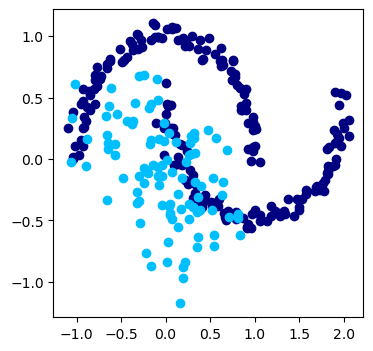

[11/50] 	Loss_D: -0.7313 	Loss_G: -0.0370
[12/50] 	Loss_D: -0.6889 	Loss_G: -0.0502
[13/50] 	Loss_D: -0.7233 	Loss_G: -0.0667
[14/50] 	Loss_D: -0.7176 	Loss_G: -0.0111
[15/50] 	Loss_D: -0.7422 	Loss_G: -0.0188
[16/50] 	Loss_D: -0.7520 	Loss_G: -0.0455
[17/50] 	Loss_D: -0.7253 	Loss_G: -0.0474
[18/50] 	Loss_D: -0.7391 	Loss_G: -0.0133
[19/50] 	Loss_D: -0.7313 	Loss_G: -0.0295
[20/50] 	Loss_D: -0.7296 	Loss_G: -0.0787


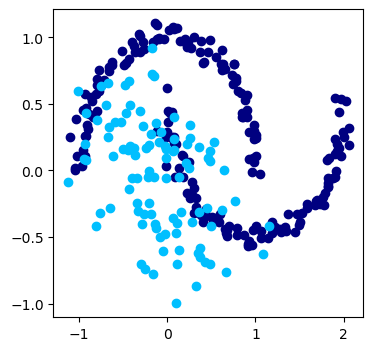

[21/50] 	Loss_D: -0.7322 	Loss_G: -0.0271
[22/50] 	Loss_D: -0.7319 	Loss_G: -0.0294
[23/50] 	Loss_D: -0.7294 	Loss_G: -0.0402
[24/50] 	Loss_D: -0.7467 	Loss_G: -0.0600
[25/50] 	Loss_D: -0.7485 	Loss_G: -0.0933
[26/50] 	Loss_D: -0.7142 	Loss_G: -0.0465
[27/50] 	Loss_D: -0.7188 	Loss_G: -0.0470
[28/50] 	Loss_D: -0.7001 	Loss_G: -0.0718
[29/50] 	Loss_D: -0.7314 	Loss_G: -0.0455
[30/50] 	Loss_D: -0.7603 	Loss_G: -0.0654


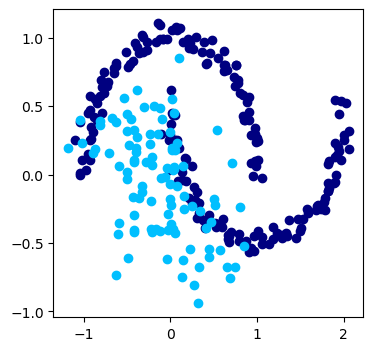

[31/50] 	Loss_D: -0.7897 	Loss_G: -0.0503
[32/50] 	Loss_D: -0.7339 	Loss_G: -0.0452
[33/50] 	Loss_D: -0.7611 	Loss_G: -0.0305
[34/50] 	Loss_D: -0.7349 	Loss_G: -0.0643
[35/50] 	Loss_D: -0.7403 	Loss_G: -0.0550
[36/50] 	Loss_D: -0.7252 	Loss_G: -0.0308
[37/50] 	Loss_D: -0.7582 	Loss_G: -0.0186
[38/50] 	Loss_D: -0.7779 	Loss_G: -0.0666
[39/50] 	Loss_D: -0.7771 	Loss_G: -0.0205
[40/50] 	Loss_D: -0.7579 	Loss_G: -0.0318


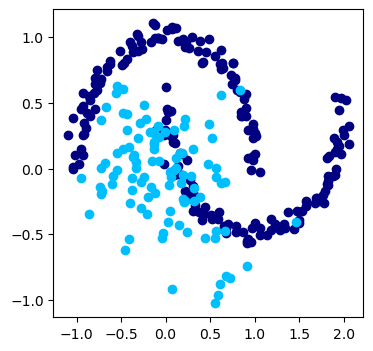

[41/50] 	Loss_D: -0.7483 	Loss_G: -0.0393
[42/50] 	Loss_D: -0.7088 	Loss_G: -0.0394
[43/50] 	Loss_D: -0.7581 	Loss_G: -0.0484
[44/50] 	Loss_D: -0.7538 	Loss_G: -0.0209
[45/50] 	Loss_D: -0.7720 	Loss_G: -0.0150
[46/50] 	Loss_D: -0.7794 	Loss_G: -0.0421
[47/50] 	Loss_D: -0.7349 	Loss_G: -0.0639
[48/50] 	Loss_D: -0.7669 	Loss_G: -0.0357
[49/50] 	Loss_D: -0.7284 	Loss_G: -0.0511


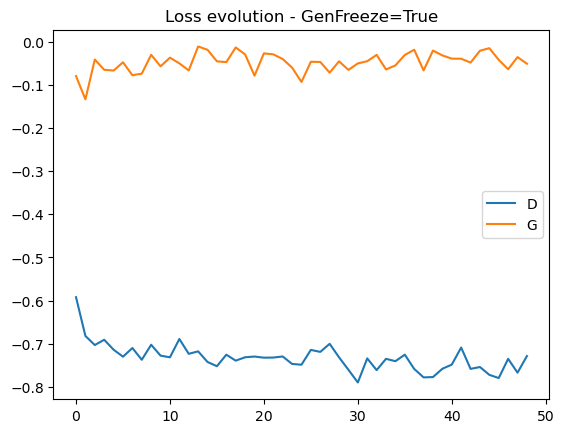

In [13]:
# First, training Discriminator with Generator frozen

train_WGAN(GenFreeze=True, lrdisc=1e-3, niterD=100, clip=True, clip_value=10.0, iter_display=10)

Training WGAN - GenFreeze=False
Clipping gradient with clip_value = 0.5
[1/100] 	Loss_D: -0.4387 	Loss_G: -0.1622
[2/100] 	Loss_D: -0.3524 	Loss_G: -0.1820
[3/100] 	Loss_D: -0.2531 	Loss_G: -0.3320
[4/100] 	Loss_D: -0.2952 	Loss_G: -0.4695
[5/100] 	Loss_D: -0.2891 	Loss_G: -0.4945
[6/100] 	Loss_D: -0.1640 	Loss_G: -0.5925
[7/100] 	Loss_D: -0.2183 	Loss_G: -0.7091
[8/100] 	Loss_D: -0.1973 	Loss_G: -0.7652
[9/100] 	Loss_D: -0.2421 	Loss_G: -0.7684
[10/100] 	Loss_D: -0.3106 	Loss_G: -0.7030


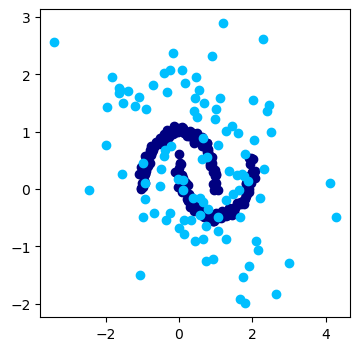

[11/100] 	Loss_D: -0.3069 	Loss_G: -0.7713
[12/100] 	Loss_D: -0.4572 	Loss_G: -0.5779
[13/100] 	Loss_D: -0.6885 	Loss_G: -0.2154
[14/100] 	Loss_D: -0.7471 	Loss_G: -0.2773
[15/100] 	Loss_D: -0.6933 	Loss_G: -0.2426
[16/100] 	Loss_D: -0.6642 	Loss_G: -0.2187
[17/100] 	Loss_D: -0.7396 	Loss_G: -0.2066
[18/100] 	Loss_D: -0.7830 	Loss_G: -0.2843
[19/100] 	Loss_D: -0.6177 	Loss_G: -0.2804
[20/100] 	Loss_D: -0.6293 	Loss_G: -0.2985


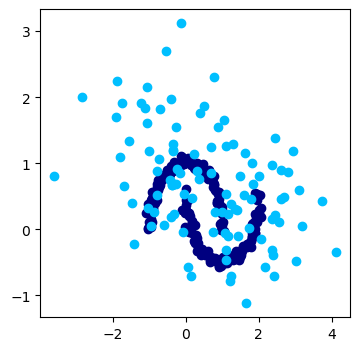

[21/100] 	Loss_D: -0.6493 	Loss_G: -0.3051
[22/100] 	Loss_D: -0.5803 	Loss_G: -0.3588
[23/100] 	Loss_D: -0.5336 	Loss_G: -0.4367
[24/100] 	Loss_D: -0.5092 	Loss_G: -0.5448
[25/100] 	Loss_D: -0.4245 	Loss_G: -0.4409
[26/100] 	Loss_D: -0.4290 	Loss_G: -0.5727
[27/100] 	Loss_D: -0.3148 	Loss_G: -0.6756
[28/100] 	Loss_D: -0.2904 	Loss_G: -0.6293
[29/100] 	Loss_D: -0.2075 	Loss_G: -0.8212
[30/100] 	Loss_D: -0.1322 	Loss_G: -0.8533


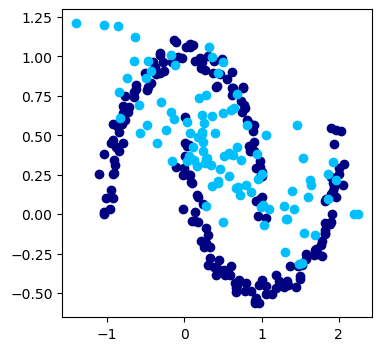

[31/100] 	Loss_D: -0.1172 	Loss_G: -0.8957
[32/100] 	Loss_D: -0.0360 	Loss_G: -0.8990
[33/100] 	Loss_D: -0.0182 	Loss_G: -0.9624
[34/100] 	Loss_D: -0.0097 	Loss_G: -0.9789
[35/100] 	Loss_D: 0.0000 	Loss_G: -0.9983
[36/100] 	Loss_D: -0.0021 	Loss_G: -0.9870
[37/100] 	Loss_D: -0.0295 	Loss_G: -0.9665
[38/100] 	Loss_D: -0.1182 	Loss_G: -0.9137
[39/100] 	Loss_D: -0.4908 	Loss_G: -0.1177
[40/100] 	Loss_D: -0.5672 	Loss_G: -0.1044


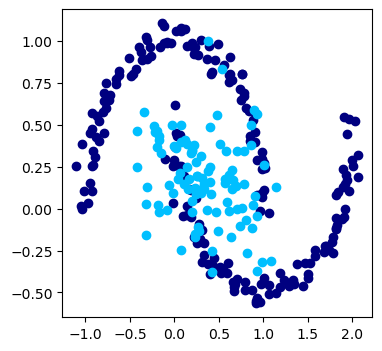

[41/100] 	Loss_D: -0.5535 	Loss_G: -0.1254
[42/100] 	Loss_D: -0.5106 	Loss_G: -0.1915
[43/100] 	Loss_D: -0.4685 	Loss_G: -0.2813
[44/100] 	Loss_D: -0.3413 	Loss_G: -0.2105
[45/100] 	Loss_D: -0.4785 	Loss_G: -0.3141
[46/100] 	Loss_D: -0.4063 	Loss_G: -0.2292
[47/100] 	Loss_D: -0.4000 	Loss_G: -0.2307
[48/100] 	Loss_D: -0.4506 	Loss_G: -0.2341
[49/100] 	Loss_D: -0.3955 	Loss_G: -0.3348
[50/100] 	Loss_D: -0.4252 	Loss_G: -0.3757


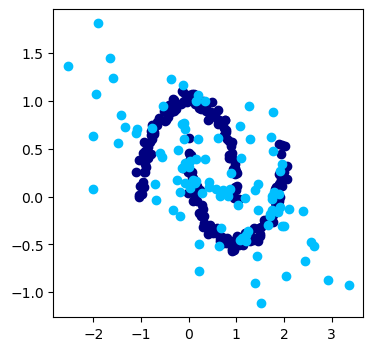

[51/100] 	Loss_D: -0.4316 	Loss_G: -0.3989
[52/100] 	Loss_D: -0.4191 	Loss_G: -0.3261
[53/100] 	Loss_D: -0.4337 	Loss_G: -0.3050
[54/100] 	Loss_D: -0.5286 	Loss_G: -0.3861
[55/100] 	Loss_D: -0.4706 	Loss_G: -0.3130
[56/100] 	Loss_D: -0.4522 	Loss_G: -0.2518
[57/100] 	Loss_D: -0.5072 	Loss_G: -0.2397
[58/100] 	Loss_D: -0.5101 	Loss_G: -0.2611
[59/100] 	Loss_D: -0.5354 	Loss_G: -0.2749
[60/100] 	Loss_D: -0.5000 	Loss_G: -0.3043


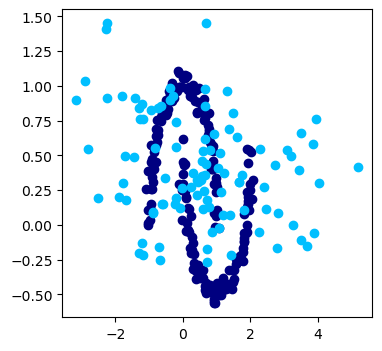

[61/100] 	Loss_D: -0.5479 	Loss_G: -0.2236
[62/100] 	Loss_D: -0.6011 	Loss_G: -0.2770
[63/100] 	Loss_D: -0.5280 	Loss_G: -0.2697
[64/100] 	Loss_D: -0.5876 	Loss_G: -0.3760
[65/100] 	Loss_D: -0.5837 	Loss_G: -0.3548
[66/100] 	Loss_D: -0.5386 	Loss_G: -0.3411
[67/100] 	Loss_D: -0.5100 	Loss_G: -0.4115
[68/100] 	Loss_D: -0.4684 	Loss_G: -0.3802
[69/100] 	Loss_D: -0.4695 	Loss_G: -0.3210
[70/100] 	Loss_D: -0.4676 	Loss_G: -0.3324


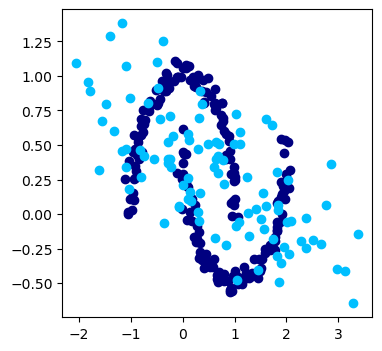

[71/100] 	Loss_D: -0.3948 	Loss_G: -0.3430
[72/100] 	Loss_D: -0.4369 	Loss_G: -0.3851
[73/100] 	Loss_D: -0.3948 	Loss_G: -0.3554
[74/100] 	Loss_D: -0.4309 	Loss_G: -0.3696
[75/100] 	Loss_D: -0.4105 	Loss_G: -0.4523
[76/100] 	Loss_D: -0.4294 	Loss_G: -0.3353
[77/100] 	Loss_D: -0.4142 	Loss_G: -0.4281
[78/100] 	Loss_D: -0.4251 	Loss_G: -0.3800
[79/100] 	Loss_D: -0.3544 	Loss_G: -0.3171
[80/100] 	Loss_D: -0.4011 	Loss_G: -0.3439


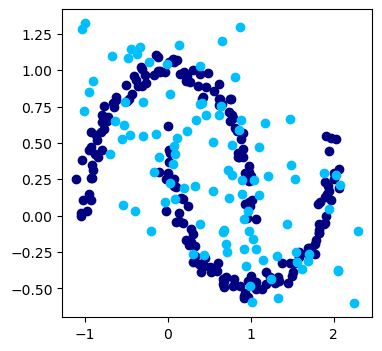

[81/100] 	Loss_D: -0.4117 	Loss_G: -0.3777
[82/100] 	Loss_D: -0.3298 	Loss_G: -0.3274
[83/100] 	Loss_D: -0.3975 	Loss_G: -0.2924
[84/100] 	Loss_D: -0.4401 	Loss_G: -0.4224
[85/100] 	Loss_D: -0.5063 	Loss_G: -0.4607
[86/100] 	Loss_D: -0.4486 	Loss_G: -0.3588
[87/100] 	Loss_D: -0.4217 	Loss_G: -0.3414
[88/100] 	Loss_D: -0.4796 	Loss_G: -0.3637
[89/100] 	Loss_D: -0.4186 	Loss_G: -0.3858
[90/100] 	Loss_D: -0.4511 	Loss_G: -0.3308


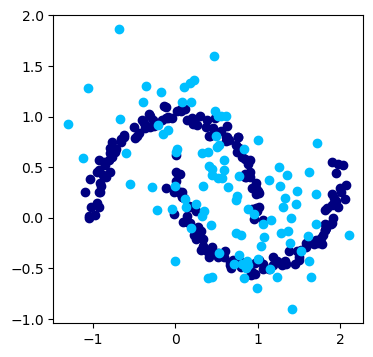

[91/100] 	Loss_D: -0.3913 	Loss_G: -0.3030
[92/100] 	Loss_D: -0.4052 	Loss_G: -0.3473
[93/100] 	Loss_D: -0.4528 	Loss_G: -0.3329
[94/100] 	Loss_D: -0.4240 	Loss_G: -0.3412
[95/100] 	Loss_D: -0.4035 	Loss_G: -0.3001
[96/100] 	Loss_D: -0.4369 	Loss_G: -0.3769
[97/100] 	Loss_D: -0.3859 	Loss_G: -0.3897
[98/100] 	Loss_D: -0.3229 	Loss_G: -0.3555
[99/100] 	Loss_D: -0.3746 	Loss_G: -0.4331


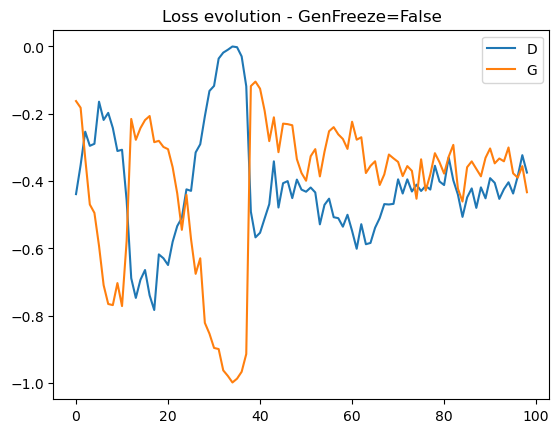

In [14]:
# Then, training both Discriminator and Generator

train_WGAN(GenFreeze=False, niterD=50, lrdisc=1e-3, iter_display=10, clip=True, n_epochs=100, clip_value=0.5)

Hum. Training failed with that set of parameters.

### WGAN-GP

Training WGAN - GenFreeze=True
Gradient penalty with lambda = 1.0
[1/50] 	Loss_D: 0.6610 	Loss_G: -0.4862 	Gradient_norm_est: 0.1572
[2/50] 	Loss_D: 0.3825 	Loss_G: -0.4022 	Gradient_norm_est: 0.3039
[3/50] 	Loss_D: 0.1919 	Loss_G: -0.3333 	Gradient_norm_est: 0.4114
[4/50] 	Loss_D: 0.0778 	Loss_G: -0.2567 	Gradient_norm_est: 0.4853
[5/50] 	Loss_D: -0.0335 	Loss_G: -0.2253 	Gradient_norm_est: 0.5546
[6/50] 	Loss_D: -0.1063 	Loss_G: -0.1556 	Gradient_norm_est: 0.6172
[7/50] 	Loss_D: -0.1950 	Loss_G: -0.1491 	Gradient_norm_est: 0.6929
[8/50] 	Loss_D: -0.2128 	Loss_G: -0.1315 	Gradient_norm_est: 0.7276
[9/50] 	Loss_D: -0.2411 	Loss_G: -0.1147 	Gradient_norm_est: 0.7977
[10/50] 	Loss_D: -0.2736 	Loss_G: -0.1137 	Gradient_norm_est: 0.7824
[11/50] 	Loss_D: -0.2685 	Loss_G: -0.1246 	Gradient_norm_est: 0.8232
[12/50] 	Loss_D: -0.2897 	Loss_G: -0.0713 	Gradient_norm_est: 0.8819
[13/50] 	Loss_D: -0.3326 	Loss_G: -0.0835 	Gradient_norm_est: 0.9105
[14/50] 	Loss_D: -0.3329 	Loss_G: -0.1062 	Gradien

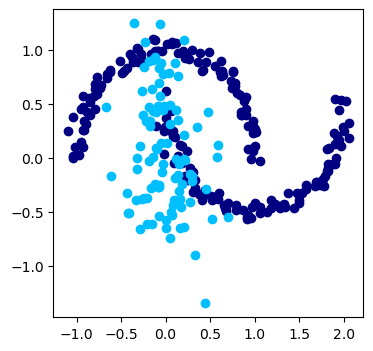

[21/50] 	Loss_D: -0.3915 	Loss_G: -0.0564 	Gradient_norm_est: 0.9286
[22/50] 	Loss_D: -0.3862 	Loss_G: -0.0803 	Gradient_norm_est: 0.9534
[23/50] 	Loss_D: -0.3725 	Loss_G: -0.0736 	Gradient_norm_est: 0.9710
[24/50] 	Loss_D: -0.3822 	Loss_G: -0.0699 	Gradient_norm_est: 0.9362
[25/50] 	Loss_D: -0.4105 	Loss_G: -0.0481 	Gradient_norm_est: 0.9706
[26/50] 	Loss_D: -0.4088 	Loss_G: -0.0569 	Gradient_norm_est: 0.9732
[27/50] 	Loss_D: -0.4166 	Loss_G: -0.0462 	Gradient_norm_est: 0.9804
[28/50] 	Loss_D: -0.4425 	Loss_G: -0.0756 	Gradient_norm_est: 0.9913
[29/50] 	Loss_D: -0.4420 	Loss_G: -0.0668 	Gradient_norm_est: 0.9834
[30/50] 	Loss_D: -0.4449 	Loss_G: -0.0600 	Gradient_norm_est: 0.9752
[31/50] 	Loss_D: -0.4557 	Loss_G: -0.0580 	Gradient_norm_est: 0.9246
[32/50] 	Loss_D: -0.4364 	Loss_G: -0.0485 	Gradient_norm_est: 0.9683
[33/50] 	Loss_D: -0.4326 	Loss_G: -0.0815 	Gradient_norm_est: 0.9879
[34/50] 	Loss_D: -0.4350 	Loss_G: -0.0442 	Gradient_norm_est: 0.9518
[35/50] 	Loss_D: -0.4578 	Loss_G: 

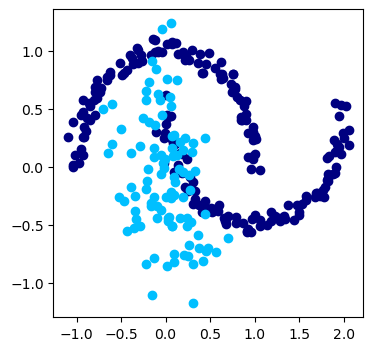

[41/50] 	Loss_D: -0.4345 	Loss_G: -0.0667 	Gradient_norm_est: 0.9844
[42/50] 	Loss_D: -0.4812 	Loss_G: -0.0398 	Gradient_norm_est: 1.0212
[43/50] 	Loss_D: -0.4631 	Loss_G: -0.0276 	Gradient_norm_est: 0.9777
[44/50] 	Loss_D: -0.4501 	Loss_G: -0.0516 	Gradient_norm_est: 0.9957
[45/50] 	Loss_D: -0.4517 	Loss_G: -0.0805 	Gradient_norm_est: 0.9018
[46/50] 	Loss_D: -0.4545 	Loss_G: -0.0593 	Gradient_norm_est: 0.8747
[47/50] 	Loss_D: -0.4732 	Loss_G: -0.0482 	Gradient_norm_est: 1.0233
[48/50] 	Loss_D: -0.4636 	Loss_G: -0.0731 	Gradient_norm_est: 1.0046
[49/50] 	Loss_D: -0.4682 	Loss_G: -0.0645 	Gradient_norm_est: 0.9808


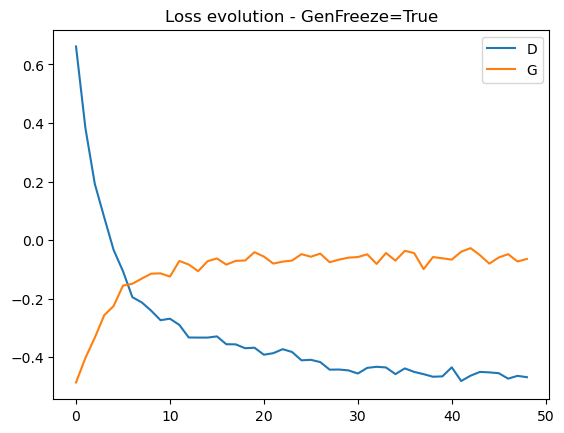

In [24]:
# First, training Discriminator with Generator frozen

train_WGAN(GenFreeze=True, lrdisc=1e-4, niterD=100, grad_penalty=True, n_epochs=50, lambd=1.0, iter_display=20)

Training WGAN - GenFreeze=False
Gradient penalty with lambda = 10.0
[1/50] 	Loss_D: 6.9978 	Loss_G: -0.5071 	Gradient_norm_est: 0.1619
[2/50] 	Loss_D: 5.0876 	Loss_G: -0.4886 	Gradient_norm_est: 0.2833
[3/50] 	Loss_D: 3.9685 	Loss_G: -0.4412 	Gradient_norm_est: 0.3673
[4/50] 	Loss_D: 2.9926 	Loss_G: -0.3877 	Gradient_norm_est: 0.4467
[5/50] 	Loss_D: 2.3877 	Loss_G: -0.4107 	Gradient_norm_est: 0.5032
[6/50] 	Loss_D: 1.9211 	Loss_G: -0.3815 	Gradient_norm_est: 0.5508
[7/50] 	Loss_D: 1.5431 	Loss_G: -0.3862 	Gradient_norm_est: 0.5910
[8/50] 	Loss_D: 1.1164 	Loss_G: -0.3503 	Gradient_norm_est: 0.6511
[9/50] 	Loss_D: 0.8913 	Loss_G: -0.3193 	Gradient_norm_est: 0.6825
[10/50] 	Loss_D: 0.6950 	Loss_G: -0.3409 	Gradient_norm_est: 0.7151
[11/50] 	Loss_D: 0.6408 	Loss_G: -0.3105 	Gradient_norm_est: 0.7292
[12/50] 	Loss_D: 0.6925 	Loss_G: -0.3574 	Gradient_norm_est: 0.7182
[13/50] 	Loss_D: 0.5448 	Loss_G: -0.3176 	Gradient_norm_est: 0.7437
[14/50] 	Loss_D: 0.2604 	Loss_G: -0.3218 	Gradient_norm_e

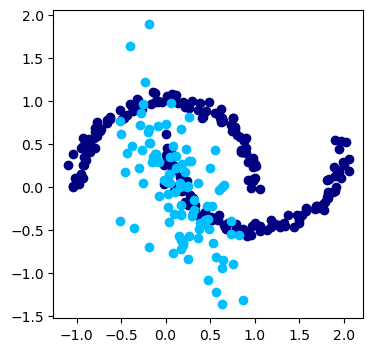

[21/50] 	Loss_D: 0.1500 	Loss_G: -0.2998 	Gradient_norm_est: 0.8556
[22/50] 	Loss_D: 0.0983 	Loss_G: -0.3285 	Gradient_norm_est: 0.8537
[23/50] 	Loss_D: 0.2077 	Loss_G: -0.3465 	Gradient_norm_est: 0.8265
[24/50] 	Loss_D: 0.1160 	Loss_G: -0.3250 	Gradient_norm_est: 0.8613
[25/50] 	Loss_D: 0.0230 	Loss_G: -0.3687 	Gradient_norm_est: 0.8937
[26/50] 	Loss_D: 0.1859 	Loss_G: -0.3464 	Gradient_norm_est: 0.8359
[27/50] 	Loss_D: -0.0150 	Loss_G: -0.3349 	Gradient_norm_est: 0.9014
[28/50] 	Loss_D: 0.1207 	Loss_G: -0.3312 	Gradient_norm_est: 0.8606
[29/50] 	Loss_D: -0.0391 	Loss_G: -0.2779 	Gradient_norm_est: 0.9188
[30/50] 	Loss_D: 0.1907 	Loss_G: -0.3166 	Gradient_norm_est: 0.8509
[31/50] 	Loss_D: 0.1639 	Loss_G: -0.3240 	Gradient_norm_est: 0.8366
[32/50] 	Loss_D: 0.2828 	Loss_G: -0.3409 	Gradient_norm_est: 0.8257
[33/50] 	Loss_D: 0.1862 	Loss_G: -0.3400 	Gradient_norm_est: 0.8734
[34/50] 	Loss_D: 0.1779 	Loss_G: -0.3336 	Gradient_norm_est: 0.8554
[35/50] 	Loss_D: 0.2715 	Loss_G: -0.3933 	Grad

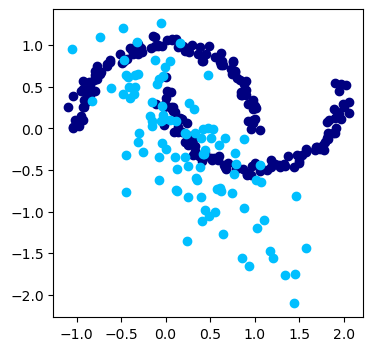

[41/50] 	Loss_D: 0.2806 	Loss_G: -0.3643 	Gradient_norm_est: 0.8273
[42/50] 	Loss_D: 0.4189 	Loss_G: -0.3487 	Gradient_norm_est: 0.8151
[43/50] 	Loss_D: 0.0383 	Loss_G: -0.4356 	Gradient_norm_est: 0.9376
[44/50] 	Loss_D: 0.2586 	Loss_G: -0.3971 	Gradient_norm_est: 0.8583
[45/50] 	Loss_D: 0.0157 	Loss_G: -0.3584 	Gradient_norm_est: 0.9215
[46/50] 	Loss_D: 0.4537 	Loss_G: -0.3993 	Gradient_norm_est: 0.8061
[47/50] 	Loss_D: 0.4092 	Loss_G: -0.3759 	Gradient_norm_est: 0.8151
[48/50] 	Loss_D: 0.2798 	Loss_G: -0.3918 	Gradient_norm_est: 0.8647
[49/50] 	Loss_D: 0.2597 	Loss_G: -0.3282 	Gradient_norm_est: 0.8287


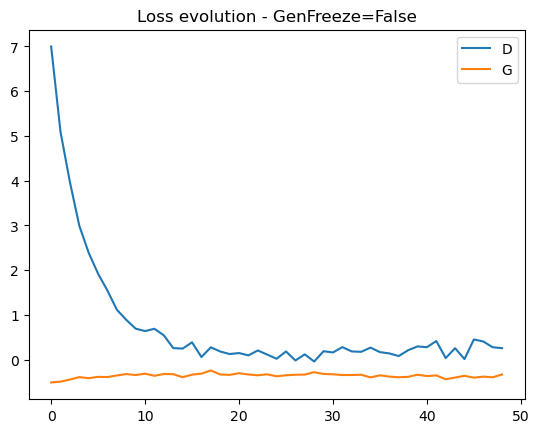

In [31]:
# Then, trying to train both Discriminator and Generator.

train_WGAN(GenFreeze=False, lrdisc=1e-4, niterD=100, lrgen=1e-4, grad_penalty=True, lambd=10.0, n_epochs=50, iter_display=20)

Still very difficult to train anything

### VAE

We code here a very simple VAE. 

The Encoder is going to encode from $\mathbb{R}^2$ into $\mathbb{R}^d$ (ie dim-d latent space), and decoder from $\mathbb{R}^d$ to $\mathbb{R}^2$.

The loss is the usual ELBO with a closed-form expression of the KL.

In [32]:
class Encoder(nn.Module):
    
    def __init__(self, n_neurons=16, latent_dim=2):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(2, n_neurons) # input dim = 2
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.fc_mu = nn.Linear(n_neurons, latent_dim)
        self.fc_logvar = nn.Linear(n_neurons, latent_dim)
        
    def forward(self,x):
        # x : B x 2
        # print(f"entrée encodeur = {x}")
        x = F.relu(self.fc1(x)) # B x n_neurons
        # print(f"1ere layer encodeur = {x}")
        x = F.relu(self.fc2(x)) # B x n_neurons
        # print(f"2e layer encodeur = {x}")
        mu = self.fc_mu(x) # B x latent_dim : mu's of the Gaussians
        # print(f"sortie mu encodeur = {mu}")
        logvar = self.fc_logvar(x) # B x latent_dim : covariance matrix (assumed diagonal) of the Gaussians
        # print(f"sortie logvar encodeur = {logvar}")
        
        return mu, logvar

In [33]:
class Decoder(nn.Module):
    
    def __init__(self, n_neurons=16, latent_dim=2):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(latent_dim, n_neurons)
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.fc3 = nn.Linear(n_neurons, 2)
        
    def forward(self,z):
        # z : B x latent_dim
        z = F.relu(self.fc1(z)) # B x n_neurons
        z = F.relu(self.fc2(z)) # B x n_neurons
        z = self.fc3(z) # B x 2
        # print(f"z_decoder = {z}")
        x_hat = z # B x 2 in [0,1]^2
        # print(f"x_hat = sigmoid(z_decoder) = {x_hat}")
        
        return x_hat

In [34]:
class ToyVAE(nn.Module):
    
    def __init__(self, n_neurons=16, latent_dim=2): #, scale=1.0):
        super(ToyVAE, self).__init__()
        
        self.encoder = Encoder(n_neurons=n_neurons, latent_dim=latent_dim)
        self.decoder = Decoder(n_neurons=n_neurons, latent_dim=latent_dim)
        # self.scale = scale
        
    def rsample(self, mean, std): #, scale=None):
        # mean : B x latent_dim
        # std : B x latent_dim
        # if scale is None:
        #     scale=self.scale
        epsilon = torch.randn_like(mean) # N(0,1) shape B x latent_dim 
        z = mean + std * epsilon # * scale # B x 1 \sim \mathcal{N}(mu, var)
        return z
    
    def forward(self,x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        # print(f"entrée de rsample : mu = {mu}")
        # print(f"entrée de rsample : std = {std}")
        z = self.rsample(mu, std)
        # print(f"sortie de rsample = {z}")
        # print(f"z samplé = {z}")
        x_hat = self.decoder(z)
        
        return x_hat, mu, logvar

In [35]:
def vae_loss(x, x_hat, mean, logvar, kl_weight=0.5):
    
    # mse = nn.MSELoss(reduction='mean')
    # reconstruction_loss = mse(x, x_hat)
    reconstruction_loss = torch.mean(torch.sum( (x-x_hat)**2, axis=1 ))
    kl_loss = - 0.5 * torch.sum( 1 + logvar - mean**2 - logvar.exp())
    
    # return reconstruction_loss + kl_loss, kl_loss, reconstruction_loss
    
    return (1-kl_weight)*(reconstruction_loss) + kl_weight*kl_loss, kl_loss, reconstruction_loss

### VAE Training loop

In [36]:
def train_VAE(
    X_data = X_data,
    n_epochs = 10,
    optimizer = None,
    model = None,
    kl_weight = 0.5
):
    
    print(f"Start training {n_epochs} epochs")
    rec_losses = []
    kl_losses = []
    losses = []
    
    # model.train()
    
    for epoch in range(n_epochs):
        # forward pass
        x_hat, mean, logvar = model(X_data)
        # backward pass
        optimizer.zero_grad()
        # print(x_hat)
        loss, kl_loss, rec_loss = vae_loss(X_data, x_hat, mean, logvar, kl_weight)
        loss.backward()
        optimizer.step()
        # reporting out
        losses.append(loss.item())
        kl_losses.append(kl_loss.item())
        rec_losses.append(rec_loss.item())
        print(f"Epoch {epoch+1} / {n_epochs} -- loss = {loss.item():.4f} -- rec_loss = {rec_loss.item():.4f} -- kl_loss = {kl_loss.item():.4f}") #, end="\r")
        
    return losses, rec_losses, kl_losses  

Checking basic AutoEncoding - we set scale at 0, so the model beahaves as a simple AutoEncoder

In [37]:
LATENT_DIM = 8

vae = ToyVAE(latent_dim=LATENT_DIM)
lr = 1e-2

optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

Start training 100 epochs
Epoch 1 / 100 -- loss = 1.4180 -- rec_loss = 1.4180 -- kl_loss = 69.2878
Epoch 2 / 100 -- loss = 1.3172 -- rec_loss = 1.3172 -- kl_loss = 59.9920
Epoch 3 / 100 -- loss = 1.2390 -- rec_loss = 1.2390 -- kl_loss = 64.0565
Epoch 4 / 100 -- loss = 1.1927 -- rec_loss = 1.1927 -- kl_loss = 74.5549
Epoch 5 / 100 -- loss = 1.1240 -- rec_loss = 1.1239 -- kl_loss = 89.6937
Epoch 6 / 100 -- loss = 1.0595 -- rec_loss = 1.0594 -- kl_loss = 109.2982
Epoch 7 / 100 -- loss = 1.0402 -- rec_loss = 1.0401 -- kl_loss = 133.2015
Epoch 8 / 100 -- loss = 0.9732 -- rec_loss = 0.9731 -- kl_loss = 161.0774
Epoch 9 / 100 -- loss = 1.0010 -- rec_loss = 1.0008 -- kl_loss = 192.1936
Epoch 10 / 100 -- loss = 0.9339 -- rec_loss = 0.9337 -- kl_loss = 223.9364
Epoch 11 / 100 -- loss = 0.9444 -- rec_loss = 0.9441 -- kl_loss = 257.5674
Epoch 12 / 100 -- loss = 0.9197 -- rec_loss = 0.9194 -- kl_loss = 296.4258
Epoch 13 / 100 -- loss = 0.8996 -- rec_loss = 0.8992 -- kl_loss = 341.5463
Epoch 14 / 10

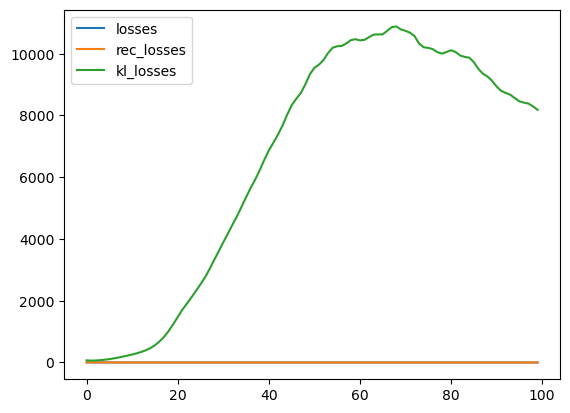

In [38]:
losses, rec_losses, kl_losses = train_VAE(X_data, optimizer=optimizer, model=vae, n_epochs=100, kl_weight=1e-6)
plt.plot(losses, label='losses')
plt.plot(rec_losses, label='rec_losses')
plt.plot(kl_losses, label='kl_losses')
plt.legend()
plt.show()

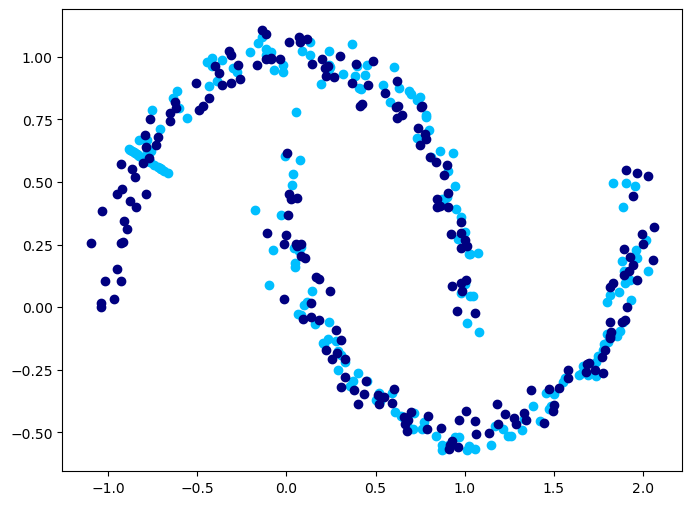

In [39]:
vae.eval()

with torch.no_grad():
    X_hat_data, mu, log_var = vae(X_data)
    
display(X_data, X_hat_data)

### Q2.a

- GANs are difficult to train by definition of their loss function, composed of KL divergences. See above.
- WGANs bring some improvement, but the Lipschitz constraint on the discriminator is difficult to enforce. When using weigh_clipping, the clip value is hard to tune. When using gradient penalty, the weight on the gradient penalty is hard to turn.
- VAE proved surprinsigly difficult to tune, even on the two-moons toy case. If the weight on the KL-loss is too strong, then the algorithm will collapse the outputs to 0, as this actually minimizes the KL-divergence of the latent variable. This is probably due to the fact that the original data lies in $\mathbb{R}^2$, and it makes little sense to encode into a higher dimension latent space.

### Q2.b

- It is clear from the drawings that the generators of the GANs and WGANs are not doing a good job at covering the data distribution. This was clear as the training of the models was not satisfactory.
- In the case of the VAE, the plot shows a much better coverage. However, this is not truly satisfactory, as we are using a latent space of higher dimension that the data space.

# MNIST

### Dataloader, etc.

In [28]:
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data
from torch.utils.data import Subset

import os

In [22]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

datapath = '/home/benjamin/Folders_Python/TP_GenAI_MVA_2025_02_25/data'
train_set = MNIST(datapath, train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [7]:
# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
      img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    plt.imshow(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

torch.Size([128, 1, 28, 28])


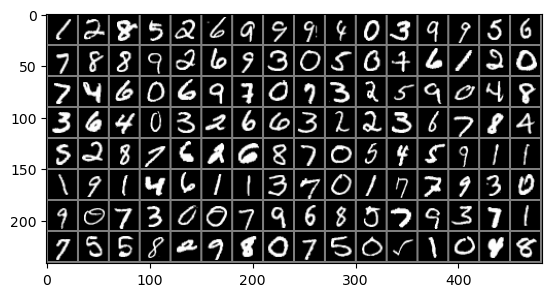

In [8]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

### WGAN

In [50]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )
        self.prob = nn.Sigmoid()

    def forward(self, input):
        return self.prob(self.main(input).view(-1, 1).squeeze(1))

# check sizes:
import torchsummary

# Create some generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

### Display samples of the Generator

z = torch.Size([128, 100, 1, 1])


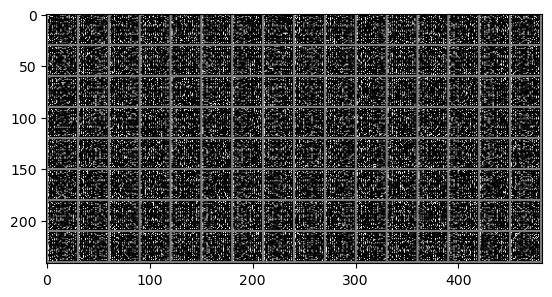

In [10]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
      print(f"z = {z.size()}")
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

# Load a pre-learned generator to see what you will get at the end of the practical session!:
G = Generator().to(device)
# G.load_state_dict(torch.hub.load_state_dict_from_url('https://perso.telecom-paristech.fr/aleclaire/mva/tp/wgan_epoch100.pt', progress=False))

# Display samples
show(G)

### Weigths Initialization

z = torch.Size([128, 100, 1, 1])


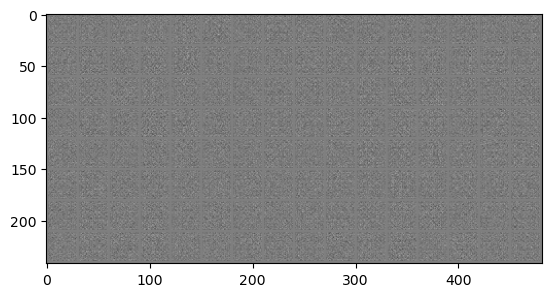

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G)

### Specific Training loop - WGAN with Gradient Clipping for MNIST

In [65]:
# smal dataloader to test the pipeline on CPU

N_SMALL = 500
subset_indices = range(N_SMALL)
subset = Subset(train_set, subset_indices)

sample_loader = data.DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [69]:
torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 3
log_every = 100
gpw = 10

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init);
D.apply(weights_init);
optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

niterD = 3

In [70]:
def est_gradient_norm(n_samples=10):
    # Estimate Gradient of Discriminator on n_samples points
            
    # Sample points from the generator
    z = torch.randn(n_samples,nz,1,1).to(device)
    x_fake_sampled = G(z) # shape : B x 1 x 28 x 28
    # print(f"x_real = {x_real.size()}")
    # print(f"x_fake_sampled = {x_fake_sampled.size()}")
            
    # # Calculate interpolation between data and generated points
    alpha = torch.rand((n_samples,1,1,1),device=device) # B x 1 x 1 x 1
    # print(f"alpha = {alpha.size()}")
    # print(f"exemple alpha = {alpha[0]}")
    interp = (alpha * x_fake_sampled + (1-alpha) * x_real[:n_samples,:,:,:]) # B x 1 x 28 x 28
    # print(f"interp = {interp.size()}")
    interp.requires_grad_()
            
    D_interp = D(interp) # B x 1
    # print(f"D_interp = {D_interp.size()}")
    gradout = torch.ones(D_interp.size()).to(device) # B x 1
    # print(f"gradouts = {gradout.size()}") # B x 1
    # autograd will actually compute a Gradient tensor B x 1 x 28 x 28, 
    # as output is D_interp shape B
    # and input is interp shape B x 1 x 28 x 28
    # ----
    # gradients is shape B x 1 x 28 x 28
    gradients = torch.autograd.grad(outputs = D_interp, inputs = interp, grad_outputs = gradout, create_graph = True, retain_graph = True)[0] # N x 2
    # print(f"gradients = {gradients.size()}")
    # -----
    # compute gradient norm estimate
    norms_squared = torch.sqrt(torch.sum(gradients**2,dim=[2,3])) # B x 1 
    # print(f"norms_squared = {norms_squared.size()}")
    est_gradient_norm = torch.mean(torch.sqrt((torch.sum(gradients**2,dim=1)))) #  1
    # print(est_gradient_norm)
    
    return est_gradient_norm

est_gradient_norm()

tensor(0.0110, grad_fn=<MeanBackward0>)

In [72]:
t0 = time.time()
list_gradient_norms = []
Dlosses = []
Dlosses_wogp = []
Glosses = []
Gradient_norms = []

for epoch in range(num_epochs):
    # For each batch in the train_loader
    losses_d_batch = []
    losses_d_wogp_batch = []
    losses_g_batch = []
    gradient_norms_batch = []
    
    for i, batch in enumerate(sample_loader, 0):
         
        # losses_batch = []
        # gradient_norm_batch = []

        ############################
        # Draw Batches 
        ############################
        
        x_real = batch[0]  # B x 1 x 28 x 28
        # print(f"x_real = {x_real.size()}")
        
        x_fake = G(torch.randn(batch_size,nz,1,1).to(device)) # B x 1 x 28 x 28
        # print(f"x_fake = {x_fake.size()}")
        
        ################################
        # Train Discriminator 
        ################################
        
        for i in range(niterD):
            # print(f"Discriminator training {i+1} / {niterD}", end="\r")
            
            optimD.zero_grad()
            # Dloss sans gradient penalty : best is -1, worst is 1
            # loss sans la régul gradient penalty
            Dloss_wogp = - (torch.mean(D(x_real)) - torch.mean(D(x_fake)))
            
            gradient_norm = est_gradient_norm()
            
            # calculate the loss with gradient penalty
            Dloss = Dloss_wogp + gpw * (gradient_norm - 1)**2
                        
            # optimize
            optimD.zero_grad()
            Dloss.backward(retain_graph=True)
            optimD.step()
          
        # iteration losses log
        losses_d_wogp_batch.append(Dloss_wogp.item())
        losses_d_batch.append(Dloss.item())
        gradient_norms_batch.append(gradient_norm.item())
    
        ############################
        # Update G network
        ############################
        
        # Gloss : best is -1, worst is 0
        Gloss = - torch.mean(D(G(torch.randn(batch_size,nz,1,1).to(device))))
        optimG.zero_grad()
        Gloss.backward()
        optimG.step()
        
        losses_g_batch.append(Gloss.item())
        
        # reporting
        print(f"batch {i+1} / {len(sample_loader)} \
            -- avg D loss sans GP = {np.average(losses_d_wogp_batch):.4f} \
            -- avg G loss = {np.average(losses_g_batch):.4f} \
            -- Gradient norm estimate : {gradient_norm:.4f}", \
            end="\r")
        
        ##############################
        ## Log 
        ##############################
        
    loss_d_wogp_epoch = np.average(losses_d_wogp_batch)
    loss_d_epoch = np.average(losses_d_batch)
    loss_g_epoch = np.average(losses_g_batch)
    gradient_norm_epoch = np.average(gradient_norms_batch)
    
    Dlosses_wogp.append(loss_d_wogp_epoch)
    Dlosses.append(loss_d_epoch)
    Glosses.append(loss_g_epoch)
    Gradient_norms.append(gradient_norm_epoch)
       
    print(f"epoch : {epoch+1} / {num_epochs} \
        --- loss D sans GP = {loss_d_wogp_epoch:.4f} \
        --- loss G = {loss_g_epoch:.4f} \
        --- gradient norm = {gradient_norm_epoch:.4f} \
                                                                ")


        


        ############################
        # Display training stats and visualize
        # if i % log_every == 0:
        #     print('[%d/%d][%d/%d][%.4f s]\tLoss_D: %.4f\tLoss_G: %.4f\tLip(D): %.4f'
        #           % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Dloss.item(), Gloss.item(),lipconstant(D,real,faked)))
        #     show(G,zviz)

tlt = time.time()-t0
print(f'Total learning time = {tlt:.4f}')

# # Save final generator in a variable for later use
# wgan = Generator()
# wgan.load_state_dict(G.state_dict())

# # Save final generator in a file
# torch.save(G.state_dict(), 'wgan.pt')





# def train_MNIST_WGAN(
#   G,
#   D,
#   GenFreeze=False,
#   niterD=100,
#   niterG=1,
#   lrdisc=1e-2,
#   lrgen=1e-3,
#   # iter_display=10,
#   n_epochs=50,
#   lambd = 1.0, # regul coeff for gradient penalty
#   grad_penalty=False
#   ):
#   """WGAN Training specific for MNIST"""
  
#   # Report out
#   print(f"Training WGAN for MNIST - GenFreeze={GenFreeze}")
  
#   if grad_penalty is False:
#     print(f"No regularization")
#   else:
#     print(f"Gradient penalty with lambda = {lambd}")
  
#   # Training loop

#   # parameters
#   lrgen = lrgen   # learning rate for generator
#   lrdisc = lrdisc  # learning rate for discriminator
#   n_epochs = n_epochs
#   niterD=niterD
#   niterG=niterG
#   lambd=lambd

#   # get ready
#   optimG = optim.Adam(G.parameters(), lr=lrgen)
#   optimD = optim.Adam(D.parameters(), lr=lrdisc) #, betas=(beta_1, beta_2))

#   # logs
#   Glosses = []
#   Dlosses = []
#   Gradient_norms = []

#   # reporting 
#   iter_display = iter_display
  
#   # misc
#   n_data = X_data.shape[0]

#   # Main loop
#   for epoch in range(1,n_epochs):

#       ###########################################
#       ### Train discriminator (niterD iterations)
#       ###########################################
      


#       #######################################
#       ### Train generator (niterG iterations)
#       #######################################


#       # Output training stats
#       if grad_penalty is False:
#         print('[%d/%d] \tLoss_D: %.4f \tLoss_G: %.4f'
#           % (epoch, n_epochs, Dloss.item(), Gloss.item()))
#       else:
#         print('[%d/%d] \tLoss_D: %.4f \tLoss_G: %.4f \tGradient_norm_est: %.4f'
#           % (epoch, n_epochs, Dloss.item(), Gloss.item(), np.average(g_norm_ests)))
#       Glosses.append(Gloss.item())
#       Dlosses.append(Dloss.item())

#       # draw pictures from time to time
#       if(epoch % iter_display == 0):
#           fig, ax = plt.subplots(figsize=(4, 4))
#           # plot data
#           ax.scatter(X_data[:,0], X_data[:,1], c='navy')
#           # plot generated points
#           z = torch.randn(b, n_in, device=device)
#           x_gen = G(z).detach().cpu().numpy()
#           ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
#           plt.show()

#   ### Plot the evolution of the discriminator and generator losses ###
#   plt.figure(dpi=100)
#   plt.plot(Dlosses,label='D')
#   plt.plot(Glosses,label='G')
#   # plt.plot(Gradient_norms, label='Gradient Norm Discriminator')
#   plt.title(f'Loss evolution - GenFreeze={GenFreeze}')
#   plt.legend()
#   plt.show()

epoch : 1 / 3         --- loss D sans GP = -0.8431         --- loss G = -0.0466         --- gradient norm = 0.0093                                                                 
epoch : 2 / 3         --- loss D sans GP = -0.9138         --- loss G = -0.0108         --- gradient norm = 0.0152                                                                 
epoch : 3 / 3         --- loss D sans GP = -0.8819         --- loss G = -0.0122         --- gradient norm = 0.0167                                                                 
Total learning time = 257.8033


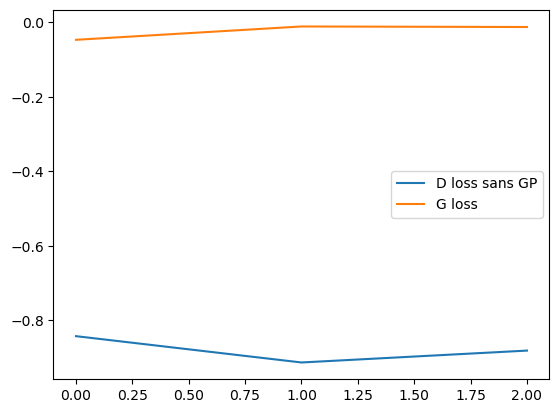

In [74]:
plt.plot(Dlosses_wogp, label="D loss sans GP")
plt.plot(Glosses, label='G loss')
plt.legend()

plt.show()